## Creating phantom for dMRI

In [18]:
import numpy as np, matplotlib.pyplot as plt

In [19]:
D_ECS   = 2.0e-3   # outside cell, free-ish water
D_CYTO  = 0.5e-3   # cytoplasm, medium
D_ORG   = 0.3e-3   # organelle, low
D_MEM   = 1e-8  # membrane, very low isotropic

# channels
D_CH_X  = (1.5e-3, 0.1e-3)  # channel 1: fast along x, slow along y
D_CH_Y  = (0.1e-3, 1.5e-3)  # channel 2: fast along y, slow along x

# fiber: fast vertically, slow horizontally
D_FIB   = (0.2e-3, 3e-3)  # (Dxx, Dyy)

In [20]:
N = 128

# inner cell box
x_cell0, x_cell1 = 16, 16 + 96  # [16, 112)
y_cell0, y_cell1 = 16, 16 + 96  # [16, 112)

In [21]:
# fiber
x_f0 = x_cell0 + 30           # 16 + 30 = 46
x_f1 = x_f0 + 8               # width ≈ 8 px (slender bar)
y_f0 = y_cell0 + 16           # 16 + 16 = 32
y_f1 = y_cell1 - 16           # 112 - 16 = 96   -> height = 64

In [22]:
# organelle
x_org1 = x_cell1 - 5          # right edge 5 px from cell border -> 112 - 5 = 107
x_org0 = x_org1 - 16          # width 16 -> 91
y_org0 = y_cell0 + 40         # 16 + 40 = 56
y_org1 = y_org0 + 16          # 72

In [23]:
ch_size = 5

y_ch1_0 = y_cell1 - 20 - ch_size   # 112 - 20 - 5 = 87
y_ch1_1 = y_ch1_0 + ch_size        # 92
x_ch1_0 = x_cell0 - 2              # extend 2 px outside cell
x_ch1_1 = x_ch1_0 + ch_size        # 3 px inside, 2 px outside

x_ch2_0 = x_cell0 + 20          # same x-position as before
x_ch2_1 = x_ch2_0 + ch_size     # width 5 px
y_ch2_0 = (y_cell1 - 1) - 2     # e.g. 111 - 2 = 109
y_ch2_1 = y_ch2_0 + ch_size     # 109..113

In [24]:
mem_top    = (y_cell0    , slice(x_cell0, x_cell1))
mem_bottom = (y_cell1-1  , slice(x_cell0, x_cell1))
mem_left   = (slice(y_cell0, y_cell1), x_cell0)
mem_right  = (slice(y_cell0, y_cell1), x_cell1-1)

In [25]:
src_x, src_y = 70, 90

In [26]:
N = 128
Dxx = np.full((N, N), D_ECS, dtype=float)
Dyy = np.full((N, N), D_ECS, dtype=float)

Y, X = np.mgrid[0:N, 0:N]

# --- cell interior: cytoplasm ---
inside_cell = (
    (X >= x_cell0) & (X < x_cell1) &
    (Y >= y_cell0) & (Y < y_cell1)
)
Dxx[inside_cell] = D_CYTO
Dyy[inside_cell] = D_CYTO

# --- membrane ring (1 px thick) ---
# top & bottom
Dxx[y_cell0, x_cell0:x_cell1] = D_MEM
Dyy[y_cell0, x_cell0:x_cell1] = D_MEM
Dxx[y_cell1-1, x_cell0:x_cell1] = D_MEM
Dyy[y_cell1-1, x_cell0:x_cell1] = D_MEM
# left & right
Dxx[y_cell0:y_cell1, x_cell0] = D_MEM
Dyy[y_cell0:y_cell1, x_cell0] = D_MEM
Dxx[y_cell0:y_cell1, x_cell1-1] = D_MEM
Dyy[y_cell0:y_cell1, x_cell1-1] = D_MEM

# --- channel 1 (fast along x) ---
mask_ch1 = (
    (X >= x_ch1_0) & (X < x_ch1_1) &
    (Y >= y_ch1_0) & (Y < y_ch1_1)
)
Dxx[mask_ch1] = D_CH_X[0]
Dyy[mask_ch1] = D_CH_X[1]

# --- channel 2 (fast along y) ---
mask_ch2 = (
    (X >= x_ch2_0) & (X < x_ch2_1) &
    (Y >= y_ch2_0) & (Y < y_ch2_1)
)
Dxx[mask_ch2] = D_CH_Y[0]       # slow along x
Dyy[mask_ch2] = D_CH_Y[1]       # fast along y

# --- fiber (anisotropic) ---
mask_fib = (
    (X >= x_f0) & (X < x_f1) &
    (Y >= y_f0) & (Y < y_f1)
)
Dxx[mask_fib] = D_FIB[0]
Dyy[mask_fib] = D_FIB[1]

# --- organelle (uniform low D) ---
mask_org = (
    (X >= x_org0) & (X < x_org1) &
    (Y >= y_org0) & (Y < y_org1)
)
Dxx[mask_org] = D_ORG
Dyy[mask_org] = D_ORG

In [27]:
c = np.zeros((N, N), dtype=float)
c[src_y, src_x] = 1.0   # point source at (70,90)

In [28]:
b = 1000.0  # toy value

D_eff_x = Dxx              # gradient direction g = (1,0)
D_eff_y = Dyy              # gradient direction g = (0,1)

S0 = np.ones((N, N))       # or some proton density mask

Sx = S0 * np.exp(-b * D_eff_x)
Sy = S0 * np.exp(-b * D_eff_y)

**Visualize phantom**

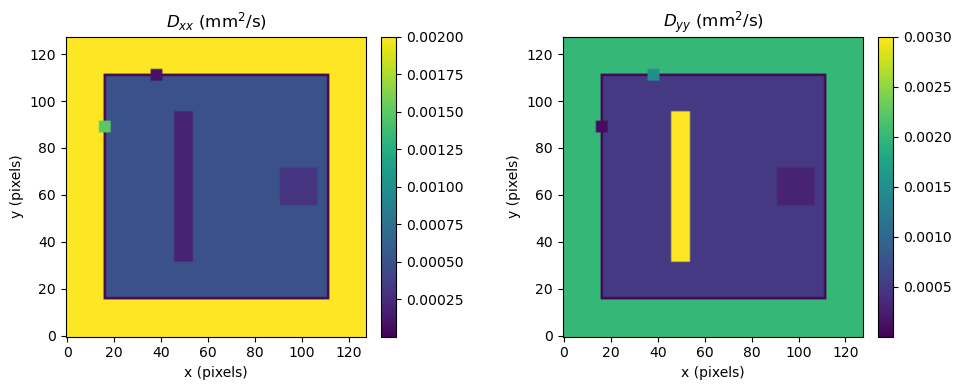

In [29]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

im0 = axs[0].imshow(Dxx, origin="lower")
axs[0].set_title(r"$D_{xx}$ (mm$^2$/s)")
axs[0].set_xlabel("x (pixels)")
axs[0].set_ylabel("y (pixels)")
fig.colorbar(im0, ax=axs[0], fraction=0.046, pad=0.04)

im1 = axs[1].imshow(Dyy, origin="lower")
axs[1].set_title(r"$D_{yy}$ (mm$^2$/s)")
axs[1].set_xlabel("x (pixels)")
axs[1].set_ylabel("y (pixels)")
fig.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

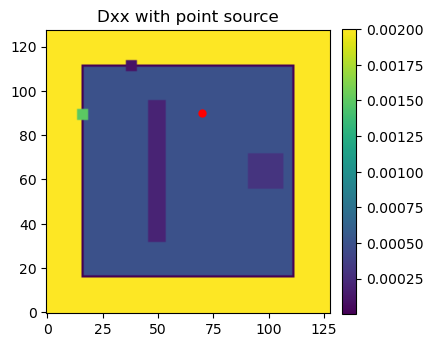

In [30]:
fig, ax = plt.subplots(figsize=(4,4))
im = ax.imshow(Dxx, origin="lower")
ax.plot(src_x, src_y, "ro", markersize=5)  # red dot for source
ax.set_title("Dxx with point source")
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.show()

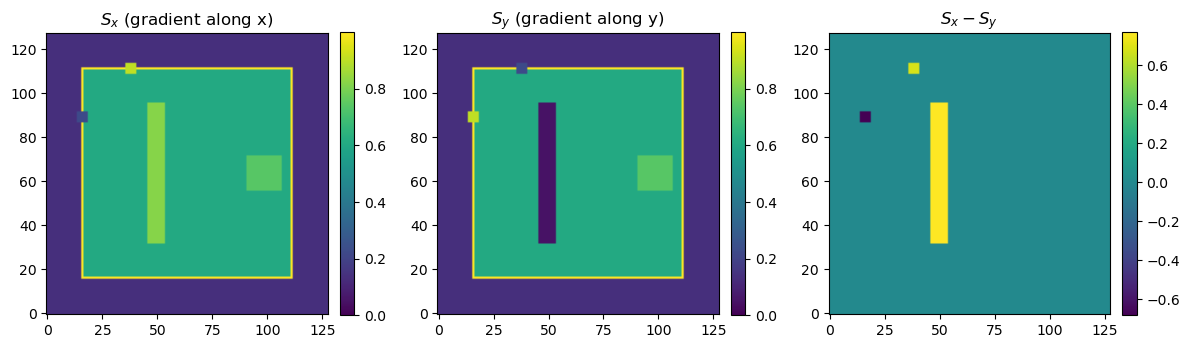

In [31]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

vmin = 0
vmax = max(Sx.max(), Sy.max())

im0 = axs[0].imshow(Sx, origin="lower", vmin=vmin, vmax=vmax)
axs[0].set_title(r"$S_x$ (gradient along x)")
fig.colorbar(im0, ax=axs[0], fraction=0.046, pad=0.04)

im1 = axs[1].imshow(Sy, origin="lower", vmin=vmin, vmax=vmax)
axs[1].set_title(r"$S_y$ (gradient along y)")
fig.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04)

# Optional: difference or ratio map
im2 = axs[2].imshow(Sx - Sy, origin="lower")
axs[2].set_title(r"$S_x - S_y$")
fig.colorbar(im2, ax=axs[2], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

In [32]:
# grid spacing (just 1 pixel units)
dx = dy = 1.0

# max diffusivity for stability estimate
Dmax = max(Dxx.max(), Dyy.max())

# time step (explicit scheme stability: dt <= 0.25 * min(dx^2,dy^2) / Dmax)
dt = 0.2 * dx**2 / Dmax   # a bit conservative

# initial condition: point source
c = np.zeros((N, N), dtype=float)
c[src_y, src_x] = 1.0

def diffusion_step(c, Dxx, Dyy, dt, dx=1.0, dy=1.0):
    """
    One explicit Euler step for
        ∂c/∂t = ∂x(Dxx ∂x c) + ∂y(Dyy ∂y c)
    with simple zero-flux (Neumann) boundaries.
    """
    c_new = c.copy()

    # interior values (shape: (N-2, N-2))
    cin = c[1:-1, 1:-1]

    # finite differences in x
    cx_plus  = (c[1:-1, 2:  ] - cin)            / dx   # c(i, j+1) - c(i, j)
    cx_minus = (cin            - c[1:-1, 0:-2]) / dx   # c(i, j)   - c(i, j-1)

    # finite differences in y
    cy_plus  = (c[2:  , 1:-1] - cin)            / dy   # c(i+1, j) - c(i, j)
    cy_minus = (cin            - c[0:-2, 1:-1]) / dy   # c(i, j)   - c(i-1, j)

    # divergence of flux: ∂x(Dxx ∂x c) + ∂y(Dyy ∂y c)
    div_x = (Dxx[1:-1, 2:  ] * cx_plus  - Dxx[1:-1, 1:-1] * cx_minus) / dx
    div_y = (Dyy[2:  , 1:-1] * cy_plus  - Dyy[1:-1, 1:-1] * cy_minus) / dy

    c_new[1:-1, 1:-1] = cin + dt * (div_x + div_y)

    # zero-flux BCs: copy neighbors at the edges
    c_new[0,  :]  = c_new[1,  :]
    c_new[-1, :]  = c_new[-2, :]
    c_new[:,  0]  = c_new[:,  1]
    c_new[:, -1]  = c_new[:, -2]

    return c_new

In [33]:
nsteps = 5000
snap_times = [0, 500, 2000, 5000]
snaps = {}

for t in range(nsteps+1):
    if t in snap_times:
        snaps[t] = c.copy()
    c = diffusion_step(c, Dxx, Dyy, dt)

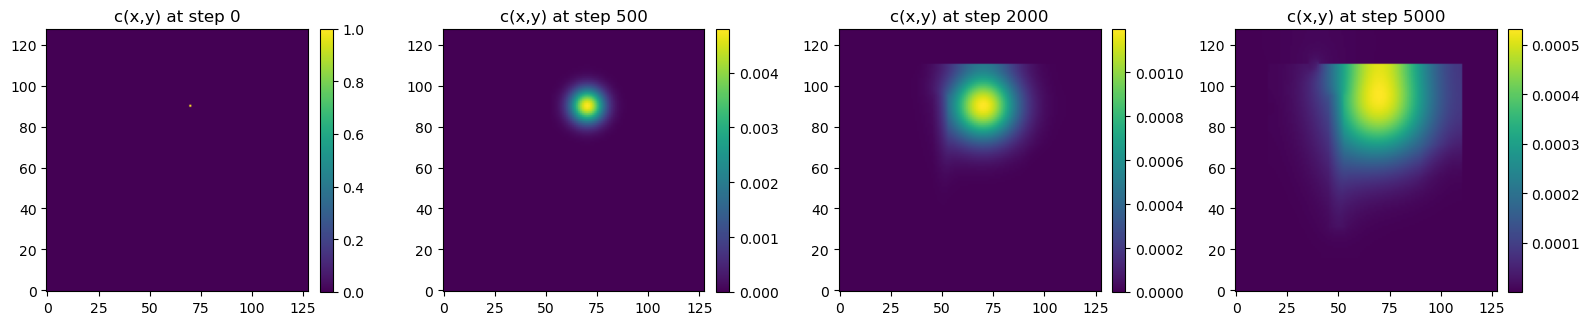

In [34]:
fig, axs = plt.subplots(1, len(snaps), figsize=(4*len(snaps), 4))
for ax, (t, img) in zip(axs, snaps.items()):
    im = ax.imshow(img, origin="lower")
    ax.set_title(f"c(x,y) at step {t}")
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()